2.18.0
Found 768 images belonging to 6 classes.
Found 189 images belonging to 6 classes.
Found 768 images belonging to 6 classes.


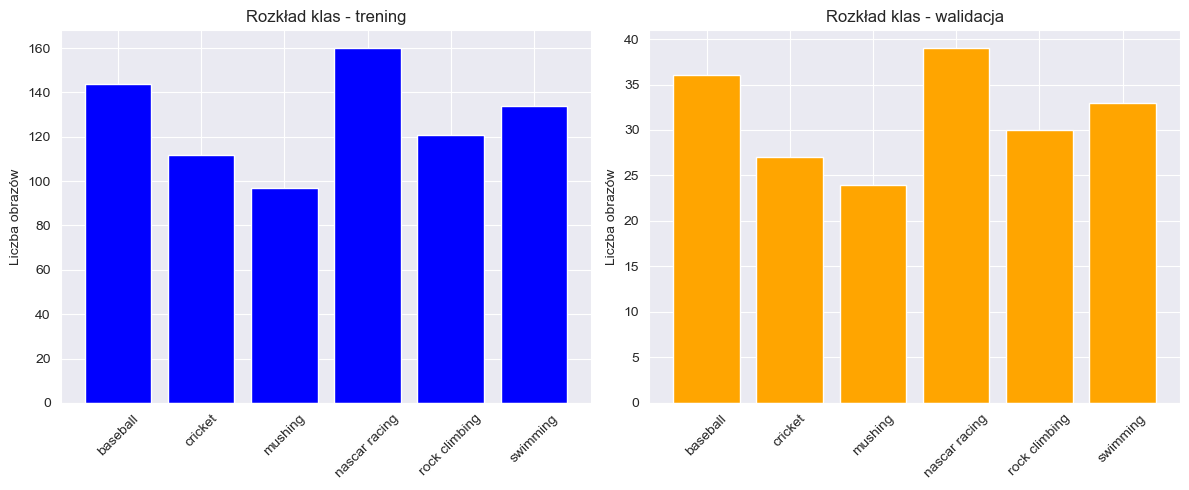

In [14]:
# sport_classification_no_transfer.ipynb

# ====================================
# 1. IMPORTY I USTAWIENIA
# ====================================
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

print(tf.__version__)  # Upewnij się, że TensorFlow działa poprawnie

# Ustawienia
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6  # 6 sportów
EPOCHS = 100
VALIDATION_SPLIT = 0.2
SEED = 42
DATA_DIR = 'data/train'

# =====================================
# 1. Ustawienie dwóch DataGeneratorów
#    z tym samym validation_split=0.2
#    i tym samym seed=42
# =====================================

# Generator BEZ augmentacji (może służyć do histogramów lub walidacji bez augmentacji)
no_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT  # 80% trening, 20% walidacja
)

# Generator Z augmentacją (używany do treningu)
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

# =====================================
# 2. Utworzenie train/valid data
# =====================================
train_data = aug_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
    subset='training',
)

valid_data = no_aug_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED,
    subset='validation',
)

train_data_eval = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
).flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED,
    subset='training'
)

# =====================================
# 3. Podgląd histogramu
# =====================================
class_labels = list(train_data.class_indices.keys())

train_labels_no_aug = train_data.classes
valid_labels_no_aug = valid_data.classes

print(train_labels_no_aug)
print(valid_labels_no_aug)

unique_train, counts_train = np.unique(train_labels_no_aug, return_counts=True)
unique_valid, counts_valid = np.unique(valid_labels_no_aug, return_counts=True)

plt.figure(figsize=(12,5))

# Zbiór treningowy - histogram przed augmentacją
plt.subplot(1, 2, 1)
plt.bar([class_labels[i] for i in unique_train], counts_train, color='blue')
plt.title('Rozkład klas - trening')
plt.xticks(rotation=45)
plt.ylabel('Liczba obrazów')

# Zbiór walidacyjny - histogram przed augmentacją
plt.subplot(1, 2, 2)
plt.bar([class_labels[i] for i in unique_valid], counts_valid, color='orange')
plt.title('Rozkład klas - walidacja')
plt.xticks(rotation=45)
plt.ylabel('Liczba obrazów')

plt.tight_layout()
plt.show()

In [15]:
# ====================================
# 3. ZBUDOWANIE SIECI CNN OD ZERA
# ====================================
model = models.Sequential()

# 1. Pierwszy blok konwolucyjny
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 2. Drugi blok konwolucyjny
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3. Trzeci blok konwolucyjny
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 4. Czwarty blok konwolucyjny (opcjonalnie można dodać jeszcze jeden)
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Spłaszczenie do wektora
model.add(layers.Flatten())

# Warstwa gęsta (Fully Connected)
model.add(layers.Dense(256, activation='relu'))

# Warstwa wyjściowa (klasyfikacja na 6 klas)
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

# 3 konwolucyjne + max pooling / gotowe architektury vgg, resnet
# vgg od zera
# resnet od transfer learningu
# sk metryki dokladnosci sieci sk learning

# ====================================
# 4. KOMPILACJA
# ====================================
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# ====================================
# 5. TRENING
# ====================================
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    validation_data=valid_data
)

# ====================================
# 6. EWALUACJA
# ====================================
val_loss, val_accuracy = model.evaluate(valid_data)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

train_loss, train_accuracy = model.evaluate(train_data_eval)
print(f"Train loss (eval set): {train_loss:.4f}, Train accuracy (eval set): {train_accuracy:.4f}")

# ====================================
# 8. ZAPISANIE MODELU
# ====================================
model.save("sport_classifier_no_transfer.keras")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,727,654 (29.48 MB)

 Trainable params: 7,727,654 (29.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 540ms/step - accuracy: 0.1738 - loss: 1.8204 - val_accuracy: 0.2063 - val_loss: 1.7517
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step - accuracy: 0.2237 - loss: 1.7325 - val_accuracy: 0.3069 - val_loss: 1.6142
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - accuracy: 0.3263 - loss: 1.6328 - val_accuracy: 0.3175 - val_loss: 1.6593
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 519ms/step - accuracy: 0.3493 - loss: 1.5090 - val_accuracy: 0.4656 - val_loss: 1.4332
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.4698 - loss: 1.3465 - val_accuracy: 0.5556 - val_loss: 1.1637
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step - accuracy: 0.5394 - loss: 1.2023 - val_accuracy: 0.5767 - val_loss: 1.0896
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.5028 - loss: 1.1857 - val_accuracy: 0.5450 - val_loss: 1.1909
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - accuracy: 0.5608 - loss: 1.0928 - 

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ścieżka do zapisanego modelu
MODEL_PATH = "sport_classifier_no_transfer.keras"

# Nazwy klas w takiej kolejności, w jakiej były trenowane w generatorze
class_names = [
    "baseball",
    "cricket",
    "mushing",
    "nascar racing",
    "rock climbing",
    "swimming"
]

# Wczytanie wytrenowanego modelu
model = load_model(MODEL_PATH)

def predict_sport(image_path, model, class_names):
    """
    Funkcja wczytuje pojedynczy obraz, przetwarza go
    i zwraca przewidywaną etykietę (oraz pewność).
    """
    # 1. Wczytanie obrazu i przeskalowanie do rozmiaru 224x224
    img = load_img(image_path, target_size=(224, 224))

    # 2. Konwersja do tablicy NumPy i normalizacja do zakresu [0, 1]
    img_array = img_to_array(img) / 255.0

    # 3. Dodanie wymiaru batch (1, 224, 224, 3), aby sieć mogła przetwarzać dane
    img_array = np.expand_dims(img_array, axis=0)

    # 4. Przewidywanie
    predictions = model.predict(img_array)  # shape: (1, NUM_CLASSES)

    # 5. Indeks klasy z najwyższym prawdopodobieństwem
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_names[predicted_index]

    # Opcjonalnie pewność predykcji (confidence)
    confidence = predictions[0][predicted_index]

    return predicted_label, confidence

# Ścieżka do przykładowego zdjęcia
test_image_path = "image12.jpg"

# Klasyfikacja
label, conf = predict_sport(test_image_path, model, class_names)

print(f"Przewidywany sport: {label}")
print(f"Pewność modelu: {conf * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Przewidywany sport: nascar racing
Pewność modelu: 94.61%


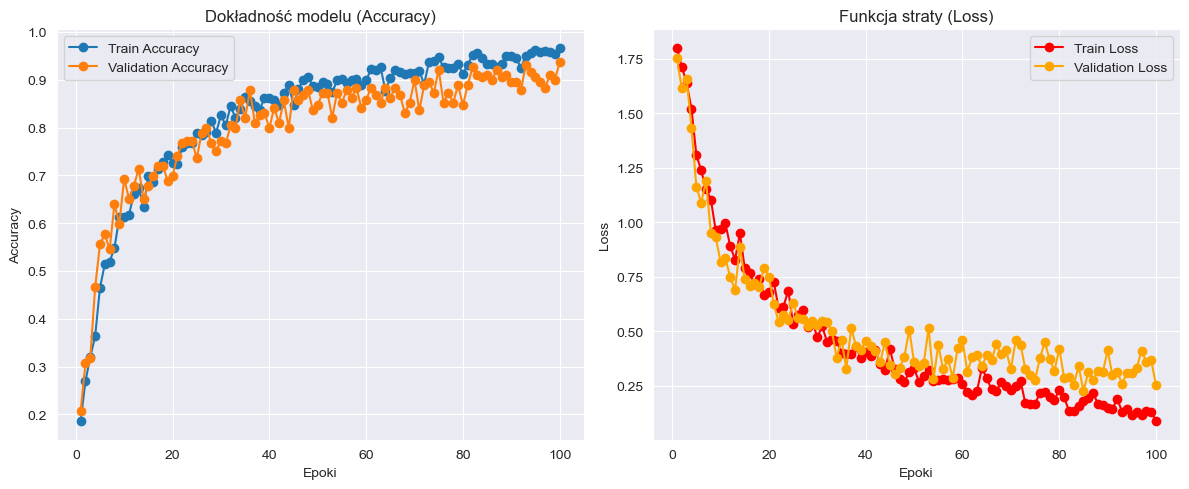

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step

🏋️‍♂️ Metryki dla zbioru treningowego:
Precision: 0.9936
Recall:    0.9935
F1-score:  0.9935


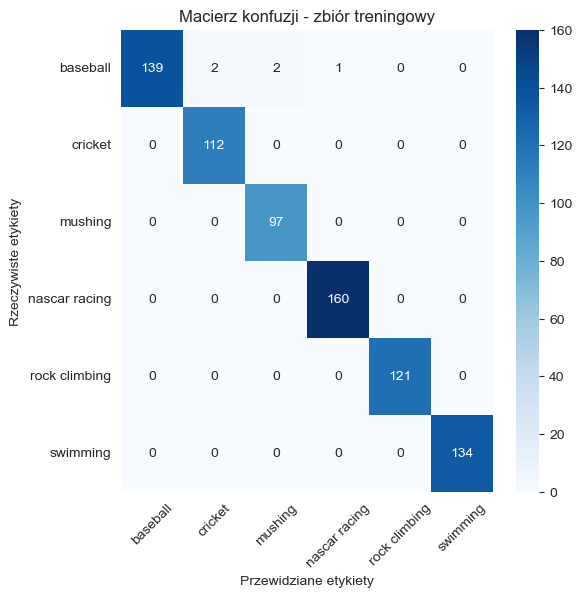


🏋️‍♂️ Raport klasyfikacji - zbiór treningowy:
               precision    recall  f1-score   support

     baseball       1.00      0.97      0.98       144
      cricket       0.98      1.00      0.99       112
      mushing       0.98      1.00      0.99        97
nascar racing       0.99      1.00      1.00       160
rock climbing       1.00      1.00      1.00       121
     swimming       1.00      1.00      1.00       134

     accuracy                           0.99       768
    macro avg       0.99      0.99      0.99       768
 weighted avg       0.99      0.99      0.99       768


🧪 Metryki dla zbioru walidacyjnego:
Precision: 0.9388
Recall:    0.9365
F1-score:  0.9359


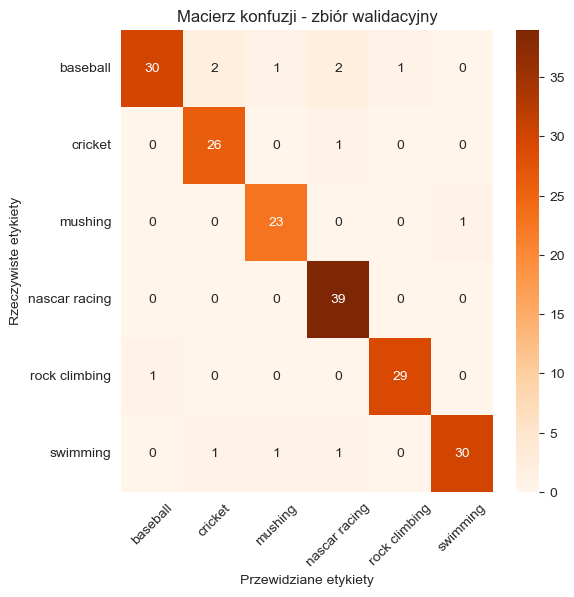


🧪 Raport klasyfikacji - zbiór walidacyjny:
               precision    recall  f1-score   support

     baseball       0.97      0.83      0.90        36
      cricket       0.90      0.96      0.93        27
      mushing       0.92      0.96      0.94        24
nascar racing       0.91      1.00      0.95        39
rock climbing       0.97      0.97      0.97        30
     swimming       0.97      0.91      0.94        33

     accuracy                           0.94       189
    macro avg       0.94      0.94      0.94       189
 weighted avg       0.94      0.94      0.94       189



In [17]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------
# 2. Wykresy z history: accuracy i loss
# -------------------------------------------------
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_acc, label="Validation Accuracy", marker='o')
plt.title("Dokładność modelu (Accuracy)")
plt.xlabel("Epoki")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Wykres funkcji straty
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss", marker='o', color='red')
plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o', color='orange')
plt.title("Funkcja straty (Loss)")
plt.xlabel("Epoki")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 3. Pobranie etykiet (y_true) i przewidywań (y_pred)
# -------------------------------------------------

# Zbiór treningowy
y_true_train = train_data_eval.classes
y_pred_train_prob = model.predict(train_data_eval)
y_pred_train = np.argmax(y_pred_train_prob, axis=1)

# Zbiór walidacyjny
y_true_valid = valid_data.classes
y_pred_valid_prob = model.predict(valid_data)
y_pred_valid = np.argmax(y_pred_valid_prob, axis=1)

# Nazwy klas
class_labels = list(train_data.class_indices.keys())

# -------------------------------------------------
# 4. Metryki dla zbioru treningowego
# -------------------------------------------------
train_precision = precision_score(y_true_train, y_pred_train, average='weighted')
train_recall    = recall_score(y_true_train, y_pred_train, average='weighted')
train_f1        = f1_score(y_true_train, y_pred_train, average='weighted')

print("\n🏋️‍♂️ Metryki dla zbioru treningowego:")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-score:  {train_f1:.4f}")

# Macierz konfuzji (train)
cm_train = confusion_matrix(y_true_train, y_pred_train)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Macierz konfuzji - zbiór treningowy")
plt.xlabel("Przewidziane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Raport klasyfikacji (train)
report_train = classification_report(y_true_train, y_pred_train, target_names=class_labels)
print("\n🏋️‍♂️ Raport klasyfikacji - zbiór treningowy:")
print(report_train)

# -------------------------------------------------
# 5. Metryki dla zbioru walidacyjnego
# -------------------------------------------------
valid_precision = precision_score(y_true_valid, y_pred_valid, average='weighted')
valid_recall    = recall_score(y_true_valid, y_pred_valid, average='weighted')
valid_f1        = f1_score(y_true_valid, y_pred_valid, average='weighted')

print("\n🧪 Metryki dla zbioru walidacyjnego:")
print(f"Precision: {valid_precision:.4f}")
print(f"Recall:    {valid_recall:.4f}")
print(f"F1-score:  {valid_f1:.4f}")

# Macierz konfuzji (valid)
cm_valid = confusion_matrix(y_true_valid, y_pred_valid)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Macierz konfuzji - zbiór walidacyjny")
plt.xlabel("Przewidziane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Raport klasyfikacji (valid)
report_valid = classification_report(y_true_valid, y_pred_valid, target_names=class_labels)
print("\n🧪 Raport klasyfikacji - zbiór walidacyjny:")
print(report_valid)